In [25]:
# import dependecies
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch
import math

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True


In [53]:
# Load
import pickle
from scipy.io import wavfile


class CausalConv1d(nn.Module):
    """1D causal convolution."""
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=self.pad, dilation=dilation
        )
        
    def forward(self, x):
        out = self.conv(x)
        if self.pad > 0:
            out = out[:, :, :-self.pad]  # remove causal padding
        return out

class ResidualBlock(nn.Module):
    """Residual block with gated activation."""
    def __init__(self, channels, kernel_size, dilation):
        super().__init__()
        self.filter_conv = CausalConv1d(channels, channels, kernel_size, dilation)
        self.gate_conv = CausalConv1d(channels, channels, kernel_size, dilation)
        self.residual_conv = nn.Conv1d(channels, channels, 1)
        self.skip_conv = nn.Conv1d(channels, channels, 1)
        
    def forward(self, x):
        out = torch.tanh(self.filter_conv(x)) * torch.sigmoid(self.gate_conv(x))
        skip = self.skip_conv(out)
        res = self.residual_conv(out) + x
        return res, skip

class WaveNet(nn.Module):
    def __init__(self, in_channels=1, channels=16, kernel_size=3, num_blocks=1, dilations=None):
        super().__init__()
        self.causal_in = CausalConv1d(in_channels, channels, kernel_size=1)
        self.dilations = dilations if dilations is not None else [2 ** i for i in range(10)]
        self.blocks = nn.ModuleList([
            ResidualBlock(channels, kernel_size, d) 
            for _ in range(num_blocks) 
            for d in self.dilations
        ])
        self.relu = nn.ReLU()
        self.out1 = nn.Conv1d(channels, channels, 1)
        self.out2 = nn.Conv1d(channels, 1, 1)

    def forward(self, x):
        x = self.causal_in(x)
        skip_connections = 0
        for block in self.blocks:
            x, skip = block(x)
            skip_connections = skip_connections + skip if isinstance(skip_connections, torch.Tensor) else skip
        out = self.relu(skip_connections)
        out = self.relu(self.out1(out))
        out = self.out2(out)
        return out

    @property
    def receptive_field(self):
        rf = 1
        for d in self.dilations:
            rf += (3 - 1) * d
        return rf

class AmpDatasetVectorized(torch.utils.data.Dataset):
    """
    Fully vectorized dataset:
    - Feed entire waveform to model at once
    - No Python slicing loops
    - Output is trimmed to match receptive field
    """
    def __init__(self, clean_wave, amp_wave, model: WaveNet):
        self.x = torch.tensor(clean_wave, dtype=torch.float32).unsqueeze(0)  # (1, L)
        self.y = torch.tensor(amp_wave, dtype=torch.float32).unsqueeze(0)    # (1, L)
        self.rf = model.receptive_field
        assert self.x.shape[-1] >= self.rf, "Waveform too short for receptive field"

    def __len__(self):
        return 1  # Entire waveform in one pass

    def __getitem__(self, idx):
        # Slice outputs to ignore initial zeros from causal padding
        x_input = self.x
        y_target = self.y[:, self.rf - 1:]  # trim first rf-1 samples
        return x_input, y_target


# model = WaveNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("model.pkl", weights_only=False, map_location="cpu").to(device)
MU = 2048

def mu_law_encode(x, mu=MU):
    x = np.clip(x, -1.0, 1.0)
    mag = np.log1p(mu * np.abs(x)) / np.log1p(mu)
    encoded = ((np.sign(x) * mag) + 1) / 2 * mu
    return np.round(encoded).astype(np.int64)
def mu_law_decode(encoded, mu=MU):
    x = (encoded.astype(np.float32) / mu) * 2 - 1
    sign = np.sign(x)
    mag = (1 / mu) * ((1 + mu) ** np.abs(x) - 1)
    return sign * mag

sr, waveform = wavfile.read("riff_clean.wav")
if waveform.ndim > 1:
    waveform = waveform.mean(axis=1)

waveform = waveform.astype(np.float32)
waveform /= np.abs(waveform).max()
# clean_quant = mu_law_encode(waveform)
model.eval()

with torch.no_grad():
    # x: 1D tensor of input waveform
    x = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, L)
    
    # forward pass
    y_pred = model(x)[:, :, model.receptive_field - 1:]  # remove initial causal padding
    
    y_pred = y_pred.squeeze(0).cpu()  # (L - rf + 1,)

# q = mu_law_decode(clean_quant)
q = y_pred.squeeze(0).numpy()

from scipy.io.wavfile import write
write("outpu11.wav", sr, (q * 32767).astype(np.int16))

/tmp/ipykernel_3544799/1122034925.py:109: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, waveform = wavfile.read("riff_clean.wav")


In [24]:
from scipy.io import wavfile

# Process clean
sr, waveform = wavfile.read("scale_clean.wav")
if waveform.ndim > 1:
    waveform = waveform.mean(axis=1)

waveform = waveform.astype(np.float32)
waveform /= np.abs(waveform).max()
clean_quant = mu_law_encode(waveform)

# Process amped
sr, waveform = wavfile.read("scale_amp.wav")
if waveform.ndim > 1:
    waveform = waveform.mean(axis=1)

waveform = waveform.astype(np.float32)
waveform /= np.abs(waveform).max()
amp_quant = mu_law_encode(waveform)

clean_tensor = torch.tensor(clean_quant, dtype=torch.float)
amp_tensor   = torch.tensor(amp_quant, dtype=torch.float)

print(clean_tensor.shape)
print(amp_tensor.shape)
# %%

# Assume WaveNet and AmpDatasetVectorized are already defined

def trim_to_match(a, b):
    slices = tuple(slice(0, min(sa, sb)) for sa, sb in zip(a.shape, b.shape))
    return a[slices]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example waveform (replace with your data)
clean_wave = clean_quant # 1D numpy array or torch tensor
amp_wave   = amp_quant  # same length

a_trimmed = trim_to_match(clean_wave, amp_wave)
b_trimmed = trim_to_match(amp_wave, clean_wave)

q = mu_law_decode(clean_quant)
from scipy.io.wavfile import write
write("outpu11.wav", sr, (q * 32767).astype(np.int16))

torch.Size([457036])
torch.Size([457035])


/tmp/ipykernel_3544799/1787534030.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, waveform = wavfile.read("scale_clean.wav")
/tmp/ipykernel_3544799/1787534030.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, waveform = wavfile.read("scale_amp.wav")


(457035,)


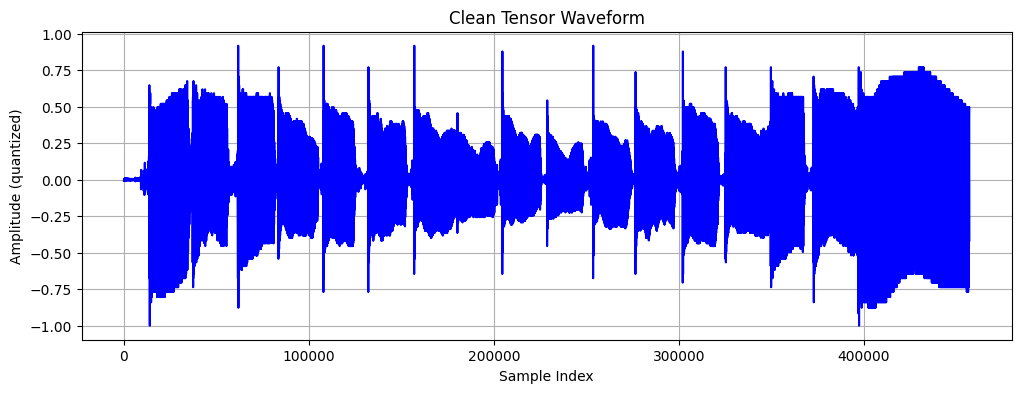

In [15]:
import torch
import matplotlib.pyplot as plt

# Assuming clean_tensor is [seq_len] or [batch_size, seq_len]
# tensor_np = pred_np
print(q.shape)
plt.figure(figsize=(12, 4))
# plt.plot(mu_law_decode(y_pred.squeeze(0).numpy()), color='blue')
plt.plot(q, color='blue')

plt.title("Clean Tensor Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude (quantized)")
plt.grid(True)
plt.show()


## Processing
mu law encoding? compresses +-1 input to 0-225. It compresses the input for better training. Not like a audio compressor for production it doesnt alter the input just makes it easier to train.

In [2]:
# mu-law for compression
# just a bunch of math that uses log compression to remove harsh sounds
# might not use dont want to compress dynamics
MU = 255

def mu_law_encode(x, mu=MU):
    x = np.clip(x, -1.0, 1.0)
    mag = np.log1p(mu * np.abs(x)) / np.log1p(mu)
    encoded = ((np.sign(x) * mag) + 1) / 2 * mu
    return np.round(encoded).astype(np.int64)

def mu_law_decode(encoded, mu=MU):
    x = (encoded.astype(np.float32) / mu) * 2 - 1
    sign = np.sign(x)
    mag = (1 / mu) * ((1 + mu) ** np.abs(x) - 1)
    return sign * mag

# Wavenet

Causal Conv
A wavenet is a cnn but is causal. this means that it hides following input for training like llms. for llms you want to predict the next set of words, so having them as inputs would be cheating and make the task really easy you would just map the input to the output. for a task like image recognition, you look at the entire image for classification. cnn's are like this. so we have to modify it to be causal for audio prediction esque tassks

resid layer
kind of a theory thing. basically if you let input flow through the model without being modifided like passing it rhough a conv1d it makes training better. 


our model uses those 2 and some embedding layer and predition head. those are just feed forward networks.

In [3]:
import torch
import torch.nn as nn

class CausalConv1d(nn.Module):
    """1D causal convolution."""
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=self.pad, dilation=dilation
        )
        
    def forward(self, x):
        out = self.conv(x)
        if self.pad > 0:
            out = out[:, :, :-self.pad]  # remove causal padding
        return out

class ResidualBlock(nn.Module):
    """Residual block with gated activation."""
    def __init__(self, channels, kernel_size, dilation):
        super().__init__()
        self.filter_conv = CausalConv1d(channels, channels, kernel_size, dilation)
        self.gate_conv = CausalConv1d(channels, channels, kernel_size, dilation)
        self.residual_conv = nn.Conv1d(channels, channels, 1)
        self.skip_conv = nn.Conv1d(channels, channels, 1)
        
    def forward(self, x):
        out = torch.tanh(self.filter_conv(x)) * torch.sigmoid(self.gate_conv(x))
        skip = self.skip_conv(out)
        res = self.residual_conv(out) + x
        return res, skip

class WaveNet(nn.Module):
    def __init__(self, in_channels=1, channels=16, kernel_size=3, num_blocks=1, dilations=None):
        super().__init__()
        self.causal_in = CausalConv1d(in_channels, channels, kernel_size=1)
        self.dilations = dilations if dilations is not None else [2 ** i for i in range(10)]
        self.blocks = nn.ModuleList([
            ResidualBlock(channels, kernel_size, d) 
            for _ in range(num_blocks) 
            for d in self.dilations
        ])
        self.relu = nn.ReLU()
        self.out1 = nn.Conv1d(channels, channels, 1)
        self.out2 = nn.Conv1d(channels, 1, 1)

    def forward(self, x):
        x = self.causal_in(x)
        skip_connections = 0
        for block in self.blocks:
            x, skip = block(x)
            skip_connections = skip_connections + skip if isinstance(skip_connections, torch.Tensor) else skip
        out = self.relu(skip_connections)
        out = self.relu(self.out1(out))
        out = self.out2(out)
        return out

    @property
    def receptive_field(self):
        rf = 1
        for d in self.dilations:
            rf += (3 - 1) * d
        return rf

class AmpDatasetVectorized(torch.utils.data.Dataset):
    """
    Fully vectorized dataset:
    - Feed entire waveform to model at once
    - No Python slicing loops
    - Output is trimmed to match receptive field
    """
    def __init__(self, clean_wave, amp_wave, model: WaveNet):
        self.x = torch.tensor(clean_wave, dtype=torch.float32).unsqueeze(0)  # (1, L)
        self.y = torch.tensor(amp_wave, dtype=torch.float32).unsqueeze(0)    # (1, L)
        self.rf = model.receptive_field
        assert self.x.shape[-1] >= self.rf, "Waveform too short for receptive field"

    def __len__(self):
        return 1  # Entire waveform in one pass

    def __getitem__(self, idx):
        # Slice outputs to ignore initial zeros from causal padding
        x_input = self.x
        y_target = self.y[:, self.rf - 1:]  # trim first rf-1 samples
        return x_input, y_target


In [4]:
# process input stuff
from scipy.io import wavfile

# Process clean
sr, waveform = wavfile.read("samples/clean/double stop.wav")
if waveform.ndim > 1:
    waveform = waveform.mean(axis=1)

waveform = waveform.astype(np.float32)
waveform /= np.abs(waveform).max()
clean_quant = mu_law_encode(waveform)

# Process amped
sr, waveform = wavfile.read("samples/real/double stop.wav")
if waveform.ndim > 1:
    waveform = waveform.mean(axis=1)

waveform = waveform.astype(np.float32)
waveform /= np.abs(waveform).max()
amp_quant = mu_law_encode(waveform)

clean_tensor = torch.tensor(clean_quant, dtype=torch.float)
amp_tensor   = torch.tensor(amp_quant, dtype=torch.float)

/tmp/ipykernel_693814/1991249156.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, waveform = wavfile.read("samples/clean/double stop.wav")
/tmp/ipykernel_693814/1991249156.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, waveform = wavfile.read("samples/real/double stop.wav")


In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Assume WaveNet and AmpDatasetVectorized are already defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example waveform (replace with your data)
clean_wave = clean_quant # 1D numpy array or torch tensor
amp_wave   = amp_quant  # same length

# Initialize model
model = WaveNet(
    in_channels=1,
    channels=16,
    kernel_size=3,
    num_blocks=1,
).to(device)

# Vectorized dataset
dataset = AmpDatasetVectorized(clean_wave, amp_wave, model)
dl = DataLoader(dataset, batch_size=1, shuffle=False)  # full waveform in one batch

# Optimizer & loss
opt = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    for x, y in dl:
        x = x.to(device)       # shape (1, L)
        y = y.to(device)       # shape (1, L-rf+1)

        opt.zero_grad()
        y_pred = model(x)[:, :, model.receptive_field - 1:]  # trim causal pad
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1} / {num_epochs}, Loss: {loss.item():.6f}")

Epoch 1 / 10000, Loss: 24187.269531
Epoch 101 / 10000, Loss: 12980.008789
Epoch 201 / 10000, Loss: 4808.869141
Epoch 301 / 10000, Loss: 2359.144531
Epoch 401 / 10000, Loss: 1509.364258
Epoch 501 / 10000, Loss: 1227.540771
Epoch 601 / 10000, Loss: 1062.007324
Epoch 701 / 10000, Loss: 1043.044067


: 

torch.Size([1, 724816])


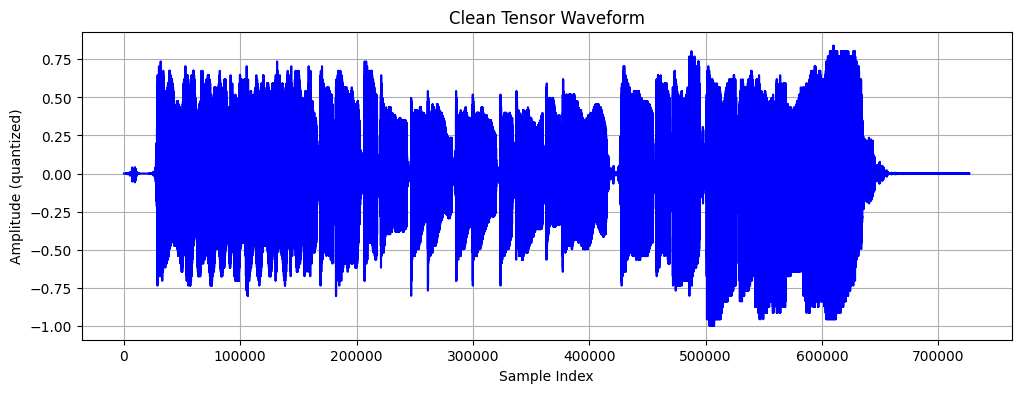

In [ ]:
model.eval()
with torch.no_grad():
    # x: 1D tensor of input waveform
    x = torch.tensor(clean_wave, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, L)
    
    # forward pass
    y_pred = model(x)[:, :, model.receptive_field - 1:]  # remove initial causal padding
    
    y_pred = y_pred.squeeze(0).cpu()  # (L - rf + 1,)

q = mu_law_decode(y_pred.squeeze(0).numpy())

In [10]:
from scipy.io.wavfile import write
write("outpu11.wav", sr, (mu_law_decode(amp_quant) * 32767).astype(np.int16))